## Setup

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FORCE_CPU = False
SEED = 2384
MODEL_NAME = "gelu-1l"

OPEN_PAREN_STR_TOKENS = ["("]
CLOSE_PAREN_STR_TOKENS = [")"]
SUPPRESSING_STR_TOKENS = ["(", "_", ",", "+", "."]

DATA_FILE = "../data/clean_data.csv"

SAVE_DATA = False
LOAD_DATA = True
TOKENISED_DATA_FILE = "saved_data/tokenised_clean_data.pt"
TRAIN_II_DATA_FILE = "saved_data/train_ii_data.pt"
TEST_II_DATA_FILE = "saved_data/test_ii_data.pt"

DATASET_MAX_SIZE = 10000
TEST_PROPORTION = 0.1
TRAIN_II_DATASET_SIZE = 10000
TEST_II_DATASET_SIZE = 1000
TRAIN_EPOCHS = 10
TRAIN_BATCH_SIZE = 16000

In [3]:
import random
from dataclasses import dataclass
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy

from causal_networks.dag import RecurrentDeterministicDAG
from causal_networks.variable_alignment import VariableAlignmentTransformer

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Low-level model

In [5]:
model = HookedTransformer.from_pretrained(MODEL_NAME, device=device)

Loaded pretrained model gelu-1l into HookedTransformer


In [6]:
d_vocab = model.tokenizer.vocab_size

In [7]:
open_paren_tokens = model.to_tokens(
    OPEN_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
open_paren_tokens = [
    open_paren_tokens[i, 0].item() for i in range(open_paren_tokens.shape[0])
]

closed_paren_tokens = model.to_tokens(
    CLOSE_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
closed_paren_tokens = [
    closed_paren_tokens[i, 0].item() for i in range(closed_paren_tokens.shape[0])
]

suppressing_tokens = model.to_tokens(
    SUPPRESSING_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
suppressing_tokens = [
    suppressing_tokens[i, 0].item() for i in range(suppressing_tokens.shape[0])
]

print("Open paren tokens:", open_paren_tokens)
print("Closed paren tokens:", closed_paren_tokens)
print("Suppressing tokens:", suppressing_tokens)

Open paren tokens: [10]
Closed paren tokens: [11]
Suppressing tokens: [10, 65, 14, 13, 16]


In [8]:
str_tokens = model.to_str_tokens(torch.arange(d_vocab), prepend_bos=False)
str_tokens[:10]

['<|EOS|>', '<|BOS|>', '<|PAD|>', '!', '"', '#', '$', '%', '&', "'"]

## Recurrent DAG

In [9]:
dag1 = RecurrentDeterministicDAG(num_streams=9)

def input_token_validator(symbol):
    return symbol in str_tokens

def interp_symbol_func(x):
    if x in OPEN_PAREN_STR_TOKENS:
        return 1
    elif x in CLOSE_PAREN_STR_TOKENS:
        return -1
    else:
        return 0
    
def cumsum_func(v):
    return sum(v)

def close_paren_func(s):
    if s > 0:
        return True
    else:
        return False
    
dag1.add_node("x", validator=input_token_validator)
dag1.add_node("v", func=interp_symbol_func)
dag1.add_node("s", func=cumsum_func)
dag1.add_node("c", func=close_paren_func, possible_values=[False, True])

dag1.add_edge("x", "v")
dag1.add_edge("v", "s", edge_type="current_and_previous_streams")
dag1.add_edge("s", "c")

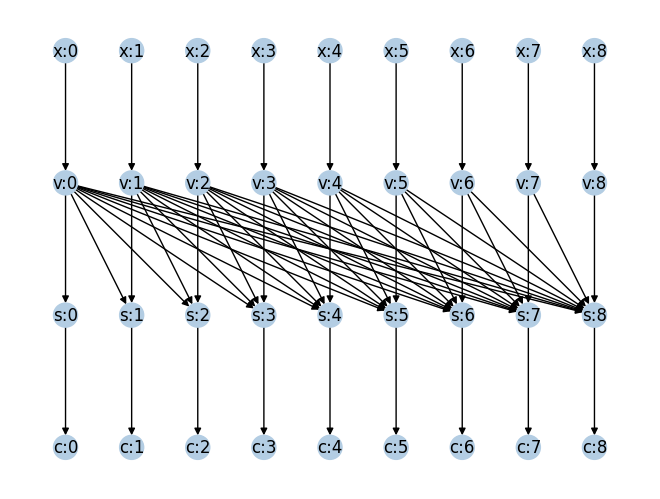

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
│ v    │ interp_symbol… │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
│ s    │ cumsum_func    │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
│ c    │ close_paren_f… │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [10]:
dag1.visualize()

In [11]:
def string_to_dag_inputs(string, truncate_length=True, output_format="list"):
    tokens = model.to_str_tokens(string)
    if truncate_length:
        tokens = tokens[: dag1.num_streams]
    if output_format == "numpy":
        tokens = np.array(tokens)
    return dict(x=tokens)

In [12]:
string1 = "(d(d)d)d"
string2 = "(d)d(d)d"
print("string1 dag input", string_to_dag_inputs(string1))
print("string2 dag input", string_to_dag_inputs(string2))

string1 dag input {'x': ['<|BOS|>', '(', 'd', '(', 'd', ')', 'd', ')', 'd']}
string2 dag input {'x': ['<|BOS|>', '(', 'd', ')', 'd', '(', 'd', ')', 'd']}


In [13]:
dag1.run(string_to_dag_inputs(string1), output_type="output_integer", output_format="torch")

tensor([[0, 1, 1, 1, 1, 1, 1, 0, 0]])

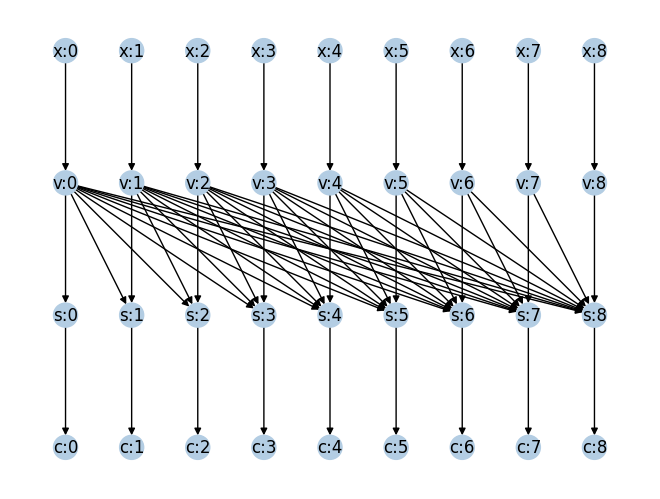

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ <|BOS|> │ (       │ d       │ (       │ d       │ )       │ d       │ )       │ d       │
│ v    │ interp_symbol… │ 0       │ 1       │ 0       │ 1       │ 0       │ -1      │ 0       │ -1      │ 0       │
│ s    │ cumsum_func    │ 0       │ 1       │ 1       │ 2       │ 2       │ 1       │ 1       │ 0       │ 0       │
│ c    │ close_paren_f… │ False   │ True    │ True    │ True    │ True    │ True    │ True    │ False   │ False   │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [14]:
dag1.visualize()

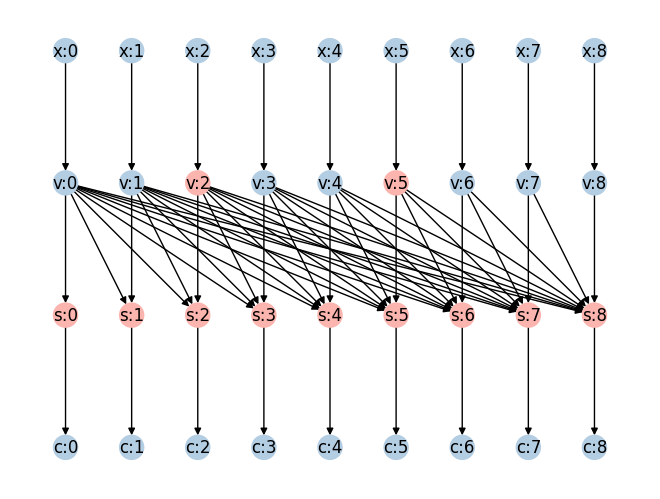

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ <|BOS|> │ (       │ d       │ (       │ d       │ )       │ d       │ )       │ d       │
│ v    │ interp_symbol… │ 0       │ 1       │ 1       │ 1       │ 0       │ 1       │ 0       │ -1      │ 0       │
│ s    │ cumsum_func    │ 50      │ 50      │ 50      │ 50      │ 50      │ 50      │ 50      │ 50      │ 50      │
│ c    │ close_paren_f… │ False   │ True    │ True    │ True    │ True    │ True    │ True    │ False   │ False   │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [15]:
dag1.intervene([("v", 2), ("v", 5), "s"], [1, 1, [50] * 9])
dag1.visualize()

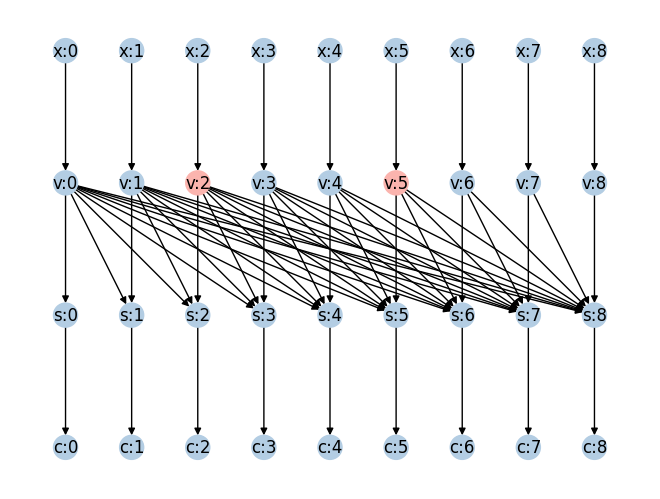

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ <|BOS|> │ (       │ d       │ (       │ d       │ )       │ d       │ )       │ d       │
│ v    │ interp_symbol… │ 0       │ 1       │ 1       │ 1       │ 0       │ 1       │ 0       │ -1      │ 0       │
│ s    │ cumsum_func    │ 0       │ 1       │ 2       │ 3       │ 3       │ 4       │ 4       │ 3       │ 3       │
│ c    │ close_paren_f… │ False   │ True    │ True    │ True    │ True    │ True    │ True    │ True    │ True    │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [16]:
dag1.intervene_and_run([("v", 2), ("v", 5)], [1, 1], inputs=string_to_dag_inputs(string1))
dag1.visualize()

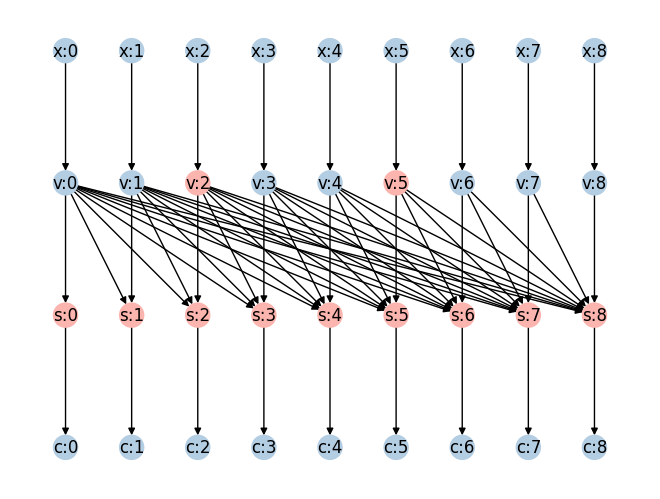

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
│ v    │ interp_symbol… │ -       │ -       │ 0       │ -       │ -       │ -1      │ -       │ -       │ -       │
│ s    │ cumsum_func    │ 0       │ 1       │ 1       │ 0       │ 0       │ 1       │ 1       │ 0       │ 0       │
│ c    │ close_paren_f… │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [17]:
dag1.do_interchange_intervention(
    [[("v", 2), ("v", 5)], ["s"]],
    [string_to_dag_inputs(string1), string_to_dag_inputs(string2)],
)
dag1.visualize()

In [18]:
def vectorised_runner(inputs, output_type="all_nodes", output_format="ordereddict"):
    x = inputs["x"]
    if x.ndim == 1:
        x = np.expand_dims(x, 0)
    v = (x == open_paren_tokens[0]).astype(int) - (x == closed_paren_tokens[0]).astype(int)
    s = np.cumsum(v, axis=1)
    c = s > 0

    if output_type == "all_nodes":
        output = OrderedDict(x=x, v=v, s=s, c=c)
    elif output_type == "output_nodes":
        output = OrderedDict(c=c)
    elif output_type == "output_integer":
        output = OrderedDict(c=c.astype(int))

    if output_format == "torch":
        output = torch.from_numpy(np.array(list(output.values())))

    return output


vectorised_runner(
    dict(
        x=to_numpy(
            model.to_tokens([string1, string2], prepend_bos=False, move_to_device=False)
        )
    ),
    output_type="all_nodes",
    output_format="ordereddict",
)

OrderedDict([('x',
              array([[10, 70, 10, 70, 11, 70, 11, 70],
                     [10, 70, 11, 70, 10, 70, 11, 70]])),
             ('v',
              array([[ 1,  0,  1,  0, -1,  0, -1,  0],
                     [ 1,  0, -1,  0,  1,  0, -1,  0]])),
             ('s',
              array([[1, 1, 2, 2, 1, 1, 0, 0],
                     [1, 1, 0, 0, 1, 1, 0, 0]])),
             ('c',
              array([[ True,  True,  True,  True,  True,  True, False, False],
                     [ True,  True, False, False,  True,  True, False, False]]))])

In [19]:
dag1.vectorised_runner = vectorised_runner

dag1.run(
    dict(
        x=to_numpy(
            model.to_tokens([string1, string2], prepend_bos=False, move_to_device=False)
        )
    ),
    vectorised=True,
    output_type="output_integer",
    output_format="torch",
)

tensor([[[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 0, 1, 1, 0, 0]]])

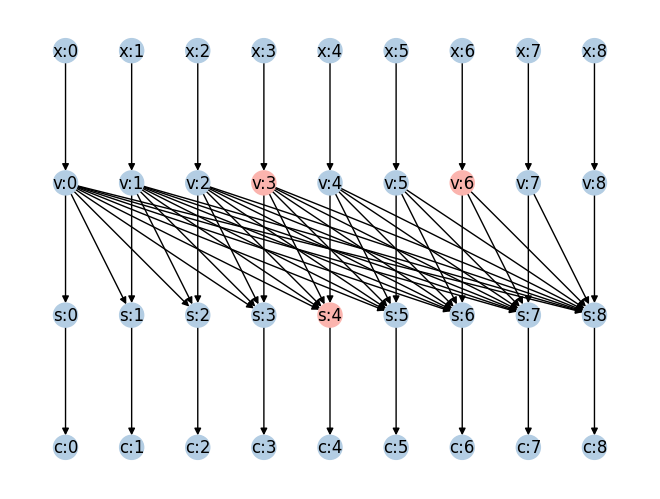

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Node ┃ Function       ┃ Value 0 ┃ Value 1 ┃ Value 2 ┃ Value 3 ┃ Value 4 ┃ Value 5 ┃ Value 6 ┃ Value 7 ┃ Value 8 ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ x    │ -              │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
│ v    │ interp_symbol… │ -       │ -       │ -       │ 0       │ -       │ -       │ -1      │ -       │ -       │
│ s    │ cumsum_func    │ -       │ -       │ -       │ -       │ 1       │ -       │ -       │ -       │ -       │
│ c    │ close_paren_f… │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │ -       │
└──────┴────────────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [20]:
source_inputs = dict(
    x=to_numpy(
        model.to_tokens(
            [string1, string2, string2], prepend_bos=False, move_to_device=False
        )
    )
)
dag1.do_interchange_intervention_vectorised_single_node_streams(
    [("v", 3), ("v", 6), ("s", 4)], source_inputs
)
dag1.visualize()

## Variable alignment

In [21]:
list(model.hook_dict.keys())

['hook_embed',
 'hook_pos_embed',
 'blocks.0.ln1.hook_scale',
 'blocks.0.ln1.hook_normalized',
 'blocks.0.ln2.hook_scale',
 'blocks.0.ln2.hook_normalized',
 'blocks.0.attn.hook_k',
 'blocks.0.attn.hook_q',
 'blocks.0.attn.hook_v',
 'blocks.0.attn.hook_z',
 'blocks.0.attn.hook_attn_scores',
 'blocks.0.attn.hook_pattern',
 'blocks.0.attn.hook_result',
 'blocks.0.mlp.hook_pre',
 'blocks.0.mlp.hook_post',
 'blocks.0.hook_q_input',
 'blocks.0.hook_k_input',
 'blocks.0.hook_v_input',
 'blocks.0.hook_attn_out',
 'blocks.0.hook_mlp_in',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_pre',
 'blocks.0.hook_resid_mid',
 'blocks.0.hook_resid_post',
 'ln_final.hook_scale',
 'ln_final.hook_normalized']

In [22]:
def input_alignment(x: torch.tensor, vectorised=False):
    if vectorised:
        return dict(x=to_numpy(x))
    if x.ndim == 1:
        return dict(x=model.to_str_tokens(x))
    elif x.ndim == 2:
        return [
            dict(
                x=model.to_str_tokens(x[i]),
            )
            for i in range(x.shape[0])
        ]
    else:
        raise ValueError("Invalid input shape")


def output_alignment(y: torch.tensor):
    return dict(y=list(to_numpy(torch.argmax(y, dim=-1))))


def output_modifier(y: torch.tensor):
    binary_output = torch.empty(*y.shape[:-1], 2, device=y.device)
    binary_output[..., 0] = y[..., open_paren_tokens].sum(dim=-1)
    binary_output[..., 1] = y[..., closed_paren_tokens].sum(dim=-1)
    
    return F.softmax(binary_output, dim=-1)

variable_alignment = VariableAlignmentTransformer(
    dag=dag1,
    low_level_model=model,
    dag_nodes=["s"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["blocks.0.hook_resid_mid"],
    subspaces_sizes=[128],
    output_modifier=output_modifier,
    device=device,
    verbosity=1,
)

Running model to determine activation space size...


In [23]:
model.to_tokens([string1, string2])

tensor([[ 1, 10, 70, 10, 70, 11, 70, 11, 70],
        [ 1, 10, 70, 11, 70, 10, 70, 11, 70]], device='cuda:0')

In [24]:
dataset = variable_alignment.create_interchange_intervention_dataset(
    model.to_tokens([string1, string2], move_to_device=False), num_samples=10
)
dataset[0]

Creating interchange intervention dataset...


Computing gold outputs: 100%|██████████| 10/10 [00:00<00:00, 2733.34it/s]


(tensor([ 1, 10, 70, 11, 70, 10, 70, 11, 70]),
 tensor([[[ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 10, 70, 11, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70]]]),
 tensor([[[ 0.1987,  0.2988, -0.2028,  ..., -0.1113,  0.0219, -0.1860],
          [ 0.0716,  0.3524,  0.1183,  ...,  0.0634,  0.1977,  0.0485],
          [ 0.2872,  0.0938,  0.4312,  ...,  0.0091,  0.4367,  0.1501],
          ...,
          [ 0.3341,  0.1542,  0.6004,  ...,  0.0055,  0.5116,  0.2204],
          [-0.0367,  0.3568,  0.1034,  ...,  0.2684,  0.2692, -0.2830],
          [ 0.3733,  0.0024,  0.3274,  ..., -0.0718,  0.6497,  0.1244]],
 
         [[ 0.1987,  0.2988, -0.2028,  ..., -0.1113,  0.0219, -0.186

In [25]:
output = variable_alignment.run_distributed_interchange_intervention(
    dataset[:][0].to(device), dataset[:][1].to(device), dataset[:][2].to(device)
)

In [26]:
output.shape

torch.Size([10, 9, 2])

In [27]:
output.argmax(dim=-1)

tensor([[0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1]], device='cuda:0')

## Data

In [28]:
data_df = pd.read_csv(DATA_FILE)

In [29]:
data_df = data_df[:DATASET_MAX_SIZE]

In [30]:
data_df.describe()

,text
count,10000
unique,9949
top,.1
freq,18


In [31]:
data_df.head()

,text
0,disabled = not self._is_active(key)
1,self._widgets[key].append(
2,self._widgets[key].append(.1
3,self._widgets[key].append(.2
4,self._widgets[key].append(.3


In [32]:
if LOAD_DATA:
    data_tokens = torch.load(TOKENISED_DATA_FILE)
else:
    data_tokens = model.to_tokens(data_df["text"].values, move_to_device=False)

if SAVE_DATA:
    torch.save(data_tokens, TOKENISED_DATA_FILE)

In [33]:
data_tokens.shape

torch.Size([10000, 95])

In [34]:
train_tokens = data_tokens[int(TEST_PROPORTION * data_tokens.shape[0]) :]
test_tokens = data_tokens[: int(TEST_PROPORTION * data_tokens.shape[0])]
print("Train tokens shape:", train_tokens.shape)
print("Test tokens shape:", test_tokens.shape)

Train tokens shape: torch.Size([9000, 95])
Test tokens shape: torch.Size([1000, 95])


## Interchange intervention training

In [35]:
if LOAD_DATA:
    train_ii_dataset = torch.load(TRAIN_II_DATA_FILE)
    test_ii_dataset = torch.load(TEST_II_DATA_FILE)
else:
    train_ii_dataset = variable_alignment.create_interchange_intervention_dataset(
        train_tokens, num_samples=TRAIN_II_DATASET_SIZE
    )
    test_ii_dataset = variable_alignment.create_interchange_intervention_dataset(
        test_tokens, num_samples=TEST_II_DATASET_SIZE
    )

if SAVE_DATA:
    torch.save(train_ii_dataset, TRAIN_II_DATA_FILE)
    torch.save(test_ii_dataset, TEST_II_DATA_FILE)

In [36]:
losses, accuracies = variable_alignment.train_rotation_matrix(
    ii_dataset=train_ii_dataset, num_epochs=TRAIN_EPOCHS, batch_size=96, lr=100
)

Epoch [1/10]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch [1/10]: 100%|██████████| 105/105 [07:08<00:00,  4.08s/it]


Loss: 0.77989, Accuracy: 0.41062


Epoch [2/10]: 100%|██████████| 105/105 [06:00<00:00,  3.43s/it]


Loss: 0.76389, Accuracy: 0.43462


Epoch [3/10]: 100%|██████████| 105/105 [07:20<00:00,  4.19s/it]


Loss: 0.75930, Accuracy: 0.44160


Epoch [4/10]: 100%|██████████| 105/105 [05:44<00:00,  3.28s/it]


Loss: 0.75659, Accuracy: 0.44569


Epoch [5/10]: 100%|██████████| 105/105 [06:43<00:00,  3.84s/it]


Loss: 0.75468, Accuracy: 0.44869


Epoch [6/10]: 100%|██████████| 105/105 [06:31<00:00,  3.73s/it]


Loss: 0.75323, Accuracy: 0.45093


Epoch [7/10]: 100%|██████████| 105/105 [07:14<00:00,  4.14s/it]


Loss: 0.75207, Accuracy: 0.45268


Epoch [8/10]: 100%|██████████| 105/105 [06:22<00:00,  3.65s/it]


Loss: 0.75112, Accuracy: 0.45403


Epoch [9/10]: 100%|██████████| 105/105 [07:25<00:00,  4.24s/it]


Loss: 0.75031, Accuracy: 0.45526


Epoch [10/10]: 100%|██████████| 105/105 [07:32<00:00,  4.30s/it]

Loss: 0.74962, Accuracy: 0.45636
